Sumber Data : https://www.kaggle.com/hgultekin/bbcnewsarchive


PERSIAPAN

In [1]:
from google.colab import drive

# Dataframe
import pandas as pd

# Split data
from sklearn.model_selection import train_test_split

# Preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Visualisasi plot
import matplotlib.pyplot as plt

Mount Google Drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
df = pd.read_csv("/content/drive/My Drive/data/bbc-news-data.csv", sep='\t')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [5]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [6]:
# drop kolom id dan text lama
df = df.drop(['filename'], axis=1)
df.head()

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [7]:
# Mengecek nilai kosong 
df.isnull().values.any()

False

Pelabelan Category

In [8]:
category = pd.get_dummies(df.category)
df_category = pd.concat([df, category], axis=1)
df_category = df_category.drop(columns='category')
df_category.head()

,title,content,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,1,0,0,0,0
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,1,0,0,0,0
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,1,0,0,0,0
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,1,0,0,0,0


In [9]:
df_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          2225 non-null   object
 1   content        2225 non-null   object
 2   business       2225 non-null   uint8 
 3   entertainment  2225 non-null   uint8 
 4   politics       2225 non-null   uint8 
 5   sport          2225 non-null   uint8 
 6   tech           2225 non-null   uint8 
dtypes: object(2), uint8(5)
memory usage: 45.8+ KB


In [13]:
# Mengubah tipe data menjadi str dan numpy array 
content = df_category['content'].astype(str)
label = df_category[['business', 'entertainment','politics','sport','tech']].values

Split Data 20%

In [14]:
category_train, category_test, label_train, label_test = train_test_split(content, label, test_size = 0.2)

Tokenizer

In [15]:
# mengkonversikan ke sequence
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(category_train) 
tokenizer.fit_on_texts(category_test)
 
sekuens_train = tokenizer.texts_to_sequences(category_train)
sekuens_test = tokenizer.texts_to_sequences(category_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

Pemodelan Sequential dengan Embedding dan Long Shor-Term Memory (LSTM)

In [21]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

Model compile dengan optimizer Adam


In [22]:
model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Fungsi Callback dengan accuracy dan val diatas 90%

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nNilai akurasi train dan validasi > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [24]:
num_epochs = 30
history = model.fit(padded_train, label_train, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
56/56 - 208s - loss: 1.6053 - accuracy: 0.2208 - val_loss: 1.5879 - val_accuracy: 0.2449 - 208s/epoch - 4s/step
Epoch 2/30
56/56 - 205s - loss: 1.3993 - accuracy: 0.3747 - val_loss: 1.1518 - val_accuracy: 0.4247 - 205s/epoch - 4s/step
Epoch 3/30
56/56 - 205s - loss: 1.0869 - accuracy: 0.4225 - val_loss: 1.0192 - val_accuracy: 0.4921 - 205s/epoch - 4s/step
Epoch 4/30
56/56 - 204s - loss: 0.9605 - accuracy: 0.4820 - val_loss: 0.9611 - val_accuracy: 0.4764 - 204s/epoch - 4s/step
Epoch 5/30
56/56 - 202s - loss: 0.8450 - accuracy: 0.6652 - val_loss: 1.2033 - val_accuracy: 0.5124 - 202s/epoch - 4s/step
Epoch 6/30
56/56 - 202s - loss: 0.8144 - accuracy: 0.6382 - val_loss: 0.7520 - val_accuracy: 0.6427 - 202s/epoch - 4s/step
Epoch 7/30
56/56 - 201s - loss: 0.4686 - accuracy: 0.7921 - val_loss: 0.6147 - val_accuracy: 0.7596 - 201s/epoch - 4s/step
Epoch 8/30
56/56 - 203s - loss: 0.3074 - accuracy: 0.8758 - val_loss: 0.6954 - val_accuracy: 0.7393 - 203s/epoch - 4s/step
Epoch 9/30
56/56

Grafik Akurasi dan Loss

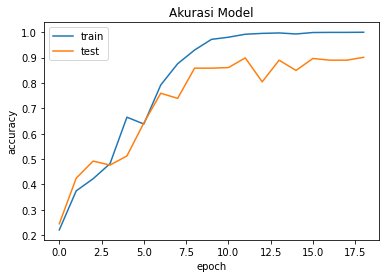

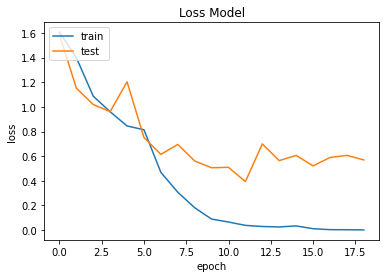

In [25]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()